### Detect difficulty of English text and visualize it

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import math

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel

from models.attention import SimpleAttention
from models.attention2 import SimpleAttention2
from models.bert import BERTClassification
from models.simple import SimpleClassification
from dataset.cefr_leveled_texts import CEFRLeveledTexts
from dataset.cefr_sp import CEFR_SP
from util.metrics import ClassificationMetrics

LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 10
LOAD_FROM = None
DATA_ROOT = Path("training_data")
NUM_CLASS = 6
EXP_FOLDER = Path("exp1")

/home/cyrus/virtualenv/text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/cyrus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cyrus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Dataset and Model

In [2]:
# dataset = CEFRLeveledTexts(DATA_ROOT / "cefr_leveled_texts.csv")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])

train_dataset = CEFR_SP("training_data/CEFR-SP", split="train")
val_dataset = CEFR_SP("training_data/CEFR-SP", split="dev")
test_dataset = CEFR_SP("training_data/CEFR-SP", split="test")

In [3]:
# train_dataset = Subset(train_dataset, np.arange(300))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataset = Subset(val_dataset, np.arange(20))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = SimpleAttention(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
model = BERTClassification(NUM_CLASS).to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")  # to get average easily
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training

In [4]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")

    model.train()
    train_loss = 0
    for batch_idx, (sentences, labels) in enumerate(train_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"[Batch {batch_idx:4d}/{len(train_loader)}] Loss: {loss.item()/BATCH_SIZE:.4f}")

    print(f"Total train loss: {train_loss/len(train_dataset):.4f}")

    model.eval()
    val_truths = []
    val_outputs = []
    for batch_idx, (sentences, labels) in enumerate(val_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        val_truths += labels.detach().cpu().tolist()
        val_outputs.append(outputs.detach().cpu())

    val_outputs = torch.cat(val_outputs)  # from list of tensor to numpy array
    metrics = ClassificationMetrics(val_truths, val_outputs)
    metrics.print_report()

    print()

Epoch [0/10]
[Batch    0/113] Loss: 1.7530
[Batch   50/113] Loss: 1.3980
[Batch  100/113] Loss: 1.2265
Total train loss: 1.3465
Accuracy: 48.32% | Precision: 0.2822
Recall:   0.2716 | F1 score:  0.2607

Epoch [1/10]
[Batch    0/113] Loss: 1.2007


### Visualize weights

In [ ]:
batch_idx, (sentences, labels) = next(enumerate(val_loader))
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
tokens_list = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

model.eval()
_, attention = model.get_attention_output(**inputs)
outputs = model(**inputs)
predictions = torch.argmax(outputs, axis=1)

cls_attn = attention[:, 0, :]
print(attention.shape)
print(cls_attn.sum())
print(predictions)

for tokens, attn in zip(tokens_list, cls_attn):
    for t in tokens:
        print(f"{t:>15}", end="")
    print()
    for a in attn.tolist():
        print(f"{a:15.4f}", end="")
    print()

torch.Size([64, 17, 17])
tensor(64.0000, device='cuda:0', grad_fn=<SumBackward0>)
tensor([2, 2, 3, 1, 1, 2, 2, 4, 3, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 1, 4, 3, 2, 3,
        1, 1, 2, 1, 2, 4, 3, 2, 2, 1, 2, 1, 3, 2, 2, 2, 2, 3, 3, 2, 4, 2, 3, 1,
        4, 3, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2], device='cuda:0')
          [CLS]          apple           roll          table          [SEP]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]          [PAD]
         0.0007         0.0023         0.1163         0.8804         0.0003         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000         0.0000
          [CLS]            one        example            use          light      dependent       reaction         photos           ##yn       ##thesis          [SEP]       

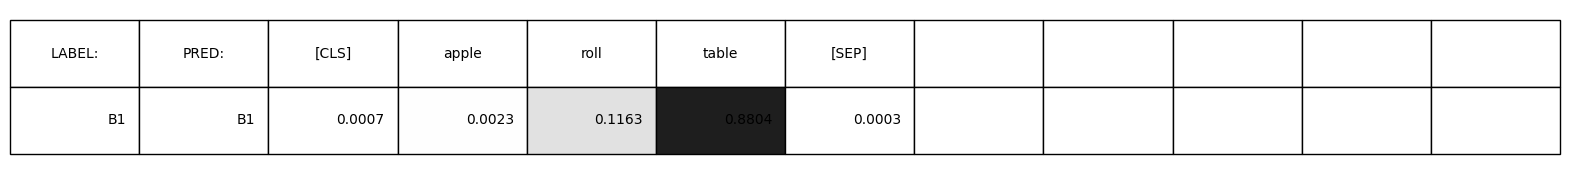

In [ ]:
i = 0
max_length = 12

tokens: list[str] = tokens_list[i]
attn = cls_attn[i].tolist()
label = CEFR_SP.target2label(labels[i].item())
prediction = CEFR_SP.target2label(predictions[i].item())

words = []
values = []
for t, a in zip(tokens, attn):
    if t == "[PAD]":
        break
    if t.startswith("##"):
        # combine subwords
        words[-1] = words[-1] + t[2:]
        values[-1] += a
    else:
        words.append(t)
        values.append(a)

words = ["LABEL:", "PRED:"] + words
attn_strs = [label, prediction] + [f"{a:.4f}" for a in values]
colors = ["w", "w"] + [str(1 - a) for a in values]


def plot_pairs(plt, words, values, colors, max_length=max_length):
    seq_length = len(words)
    if seq_length < max_length:
        words += [""] * (max_length - seq_length)
        values += [""] * (max_length - seq_length)
        colors += ["w"] * (max_length - seq_length)
    plt.axis("off")
    table = plt.table(cellText=[values], cellColours=[colors], colLabels=words, loc="center")
    table.scale(1, 4)


num_lines = math.ceil(len(words) / max_length)
fig, ax = plt.subplots(num_lines, 1, figsize=(20, 2 * num_lines))
if num_lines == 1:
    plot_pairs(ax, words, attn_strs, colors)
else:
    for i in range(num_lines):
        s, e = i * max_length, (i + 1) * max_length
        plot_pairs(ax[i], words[s:e], attn_strs[s:e], colors[s:e])

plt.show()